In [4]:
import os
import sys
import logging
import numpy as np
import ctypes as ct
import matplotlib.pyplot as plt
import time

import qcodes as qc
import qcodes.instrument.parameter as parameter
from qdev_wrappers.file_setup import my_init
from qdev_wrappers.logger import start_logging
from qdev_wrappers.show_num import show_num, show_meta
from qdev_wrappers.station_configurator import StationConfigurator
from qdev_wrappers.sweep_functions import do1d, do2d, do0d
import qcodes.instrument_drivers.Spectrum.M4i_controller as M4i_controller
import qcodes.instrument_drivers.Spectrum.pyspcm as pyspcm

from qcodes.instrument_drivers.stanford_research.SR570 import CurrentParameter
import qcodes.instrument_drivers.tektronix.Keithley_2400 as keithley
import qcodes.instrument_drivers.agilent.Agilent_33500B as awg
import qcodes.instrument_drivers.rohde_schwarz.SGS100A as rs_gen
import qcodes.instrument_drivers.Spectrum.pyspcm as pyspcm

In [2]:
STATION = qc.Station()    
# Set up experiment folders, settings and logging for the experiment. 
# The init script can be changed if desired.
my_init("M4I reflectometry", 
        STATION,
        pdf_folder=True, 
        analysis_folder=True,
        waveforms_folder=True,
        annotate_image=False, 
        mainfolder=None, 
        display_pdf=True,
        display_individual_pdf=False, 
        qubit_count=0, 
        instr_config=False,
        plot_x_position=0.66)

# Start the station with the isntruments given in setup.yaml, 
# if not specified it uses default set in qcodesrc
SC = StationConfigurator('setup.yaml', station = STATION)

In [5]:
reflectometry = M4i_controller.M4i(name='M4i')

C:\ProgramData\Anaconda3\lib\site-packages\qcodes\instrument\parameter.py:244: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


In [6]:
awg = SC.load_instrument('AgiAWG1CH1')

VisaIOError: VI_ERROR_INTF_NUM_NCONFIG (-1073807195): The interface type is valid but the specified interface number is not configured.

In [7]:
# sample rate can only be set to 250, 125, 62.5, 31.25,  15.625, 7.8125  MHz etc...  the function will auto correct to nearest sample rate
# don't set above 250e6,this will crash the code and restart the kernel will resolve.
# print out to see
reflectometry.sample_rate(500e3)
reflectometry.sample_rate() 

reflectometry.input_path('buf')  # 0: 'buf' for DC input, 1: 'hf' for AC input
reflectometry.input_coupling('DC') # 0: 'DC' or 1: 'AC' coupling
reflectometry.input_range(1000) # in mV unit
reflectometry.impedance(50) # 0: terminated 50 Ohm or 1: 1000000 high z impedance
reflectometry.compensation('disable') # 0: 'disabled' or '1': enable compensation
reflectometry.averages(100)

# DC offset for I and Q to avoid the divide by zero problem
reflectometry.Q_DC(10)   
reflectometry.I_DC(10) 

# parameters for seting up awg
reflectometry.frequency(83.)
reflectometry.start(0.48)
reflectometry.end(0.58)  



In [8]:
reflectometry.sample_rate() 


488281

In [9]:
# safe to run if size is below 8000
reflectometry.posttrigger_memory_size()

4096

In [8]:
reflectometry.setup_AWG(awg)

AttributeError: module 'qcodes.instrument_drivers.agilent.Agilent_33500B' has no attribute 'phase'

In [10]:
reflectometry.input_path()

'buf'

In [11]:
# needs  list of  channels     and  start, end etc to be defined
# acquisition1 returns   I Q mag AND phase
reflectometry.acquisition1.setup_sweep([0,1]) 

In [12]:
data = qc.Measure(reflectometry.acquisition1).run()

DataSet:
   location = 'D:\\Jingyu\\specturm test\\M4I reflectometry\\052'
   <Type>   | <array_id>    | <array.name> | <array.shape>
   Setpoint | Sweep_set     | Sweep        | (2960,)
   Measured | M4i_I         | I            | (2960,)
   Measured | M4i_Q         | Q            | (2960,)
   Measured | M4i_magnitude | magnitude    | (2960,)
   Measured | M4i_phase     | phase        | (2960,)
acquired at 2018-10-22 10:17:08


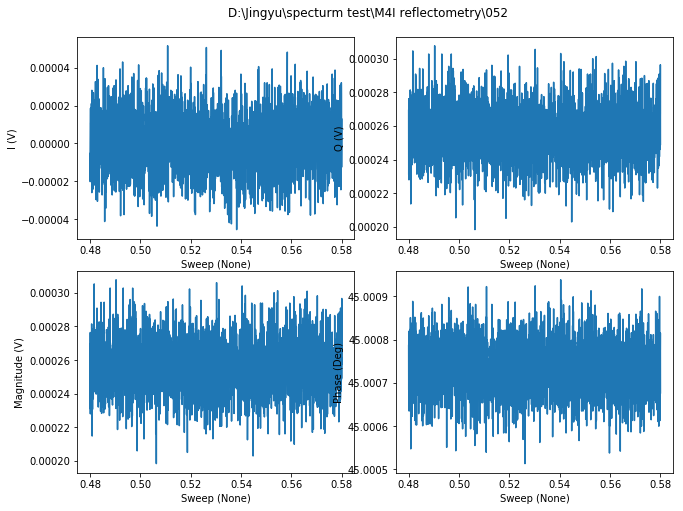

In [13]:
plot = qc.MatPlot(subplots=(2,2))
plot.add(data.M4i_I)
plot.add(data.M4i_Q,subplot=2)
plot.add(data.M4i_magnitude,subplot=3)
plot.add(data.M4i_phase,subplot=4)

In [7]:
# needs  list of  channels     and  start, end etc to be defined
# acquisition1 returns   I Q mag phase and X Y and R

reflectometry.acquisition2.setup_sweep([0,1,2,3]) 

2960


In [ ]:
data2 = qc.Measure(reflectometry.acquisition2).run()

In [ ]:
plot = qc.MatPlot(subplots=(4,2))
plot.add(data2.M4i_I)
plot.add(data2.M4i_Q,subplot=2)
plot.add(data2.M4i_magnitude,subplot=3)
plot.add(data2.M4i_phase,subplot=4)
plot.add(data2.M4i_X,subplot=5)
plot.add(data2.M4i_Y,subplot=6)
plot.add(data2.M4i_R,subplot=7)

In [ ]:
def checkTemp():
    if reflectometry.temperature() > 75:
        reflectometry.close()

In [ ]:
plot, data = do1d(qdac.Sdc,0.018,-0.018,100,0.003,reflectometry.acquisition2, reflectometry.temperature,qc.Task(checkTemp))

In [ ]:
qdac.Sds(0)

In [ ]:
awg.amplitude(0.01)
awg.offset(0)

In [14]:
reflectometry.close()